In [1]:
import os
import pandas as pd
import sys
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from creds import getCensusAPI

path = os.path.abspath('')


In [2]:
#Load raw tract-wise data
fcc_path = path+'\\static-data\\cleaned_fcc_tracts.csv'

fcc_data = pd.read_csv(fcc_path)

fcc_data.drop(['Unnamed: 0'], axis=1, inplace=True)

fcc_data['state'] = fcc_data['state'].astype(str).str.zfill(2)
fcc_data['tract'] = fcc_data['tract'].astype(str).str.zfill(6)
fcc_data['county'] = fcc_data['county'].astype(str).str.zfill(3)

fcc_data.describe()

,Max Advertised Downstream Speed (mbps)
count,72987.000000
mean,838.148725
std,725.073403
min,2.000000
25%,940.000000
50%,1000.000000
75%,1000.000000
max,10000.000000


In [3]:
#Current threshold = 50mbps, further narrow down if needed, add labels to blocks
threshold = 50

fcc_data['Access'] = np.nan
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0

C:\Users\lkyoo\AppData\Local\Temp\ipykernel_25132\1412316767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
C:\Users\lkyoo\AppData\Local\Temp\ipykernel_25132\1412316767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0


In [4]:
print('{}% of census tracts lack access to sufficient internet speeds'.format(round((fcc_data['Access'].value_counts()[0]/len(fcc_data['Access']))*100,2)))

9.71% of census tracts lack access to sufficient internet speeds


https://api.census.gov/data/2020/acs/acs5/variables.html

In [5]:
cols = {
    #Population
    'B01003_001E':'Total',
    #Sex
    'B01001_002E':'Total Male',
    'B01001_026E':'Total Female',
    #Age
    'B01002_001E': 'Median Age',
    'B29001_002E': '18 to 29 years',
    'B29001_003E': '30 to 44 years',
    'B29001_004E': '45 to 64 years',
    'B29001_005E': '65 years and over',
    #Race 
    'C02003_003E': 'White',
    'C02003_004E': 'Black or African American',
    'C02003_005E': 'American Indian and Alaska Native',
    'C02003_006E': 'Asian',
    'C02003_007E': 'Native Hawaiian and Other Pacific Islander',
    'C02003_008E': 'Some other race',
    'C02003_009E': 'Two or more races',
    'C02003_010E': 'Two or more including some other race',
    'C02003_011E': 'Two or more excluding some other race, and three or more',
    'B03001_003E': 'Hispanic or Latino',
    #Citizenship
    'B05001_006E': 'Not a Citizen',
    #Birth
    'B05012_002E': 'Native',
    'B05012_003E': 'Foreign Born',
    #English and language proficiency
    'B06007_002E': 'Speak only English',
    'B06007_003E': 'Speak Spanish',
    'B06007_004E': 'Speak Spanish, English very well',
    'B06007_005E': 'Speak Spanish, English less than very well',
    'B06007_006E': 'Speak other languages',
    'B06007_007E': 'Speak other language, English very well',
    'B06007_008E': 'Speak other language, English less than very well',
    #Individual income
    'B06010_002E': 'No individual income (12mo)',
    'B06010_003E': 'With individual income (12mo)',
    'B06010_004E': 'Less than 10000 individual income (12mo)',
    'B06010_005E': '10000 - 14999 individual income (12mo)',
    'B06010_006E': '15000 - 24999 individual income (12mo)',
    'B06010_007E': '25000 - 34999 individual income (12mo)',
    'B06010_008E': '35000 - 49999 individual income (12mo)',
    'B06010_009E': '50000 - 64999 individual income (12mo)',
    'B06010_010E': '65000 - 74999 individual income (12mo)',
    'B06010_011E': '75000 or more individual income (12mo)',
    'B06011_001E': 'Median individual income (12mo)',
    #Poverty level comparisons
    'B05010_002E': 'Ratio of income to poverty < 1.00',
    'B05010_010E': 'Ratio of income to poverty 1.00 to 1.99',
    'B05010_018E': 'Ratio of income to poverty > 1.99',
    'B06012_002E': 'Below 100% of poverty level',
    'B06012_003E': '100 to 149% of poverty level',
    'B06012_004E': 'At or above 150% of poverty level',
}

In [6]:
cols2 = {
    #Education
    'B07009_002E': 'Less than High School',
    'B06009_003E': 'High School Grad',
    'B06009_004E': 'Some college or associate degree',
    'B06009_005E': 'Bachelor',
    'B06009_006E': 'Graduate or professional degree',
    #Educational Attainment for 25 and over
    'B15003_002E': 'No schooling completed (25 and over)',
    'B15003_003E': 'Nursery (25 and over)',
    'B15003_004E': 'Kindergarten (25 and over)',
    'B15003_005E': '1st grade (25 and over)',
    'B15003_006E': '2nd grade (25 and over)',
    'B15003_007E': '3rd grade (25 and over)',
    'B15003_008E': '4th grade (25 and over)',
    'B15003_009E': '5th grade (25 and over)',
    'B15003_010E': '6th grade (25 and over)',
    'B15003_011E': '7th grade (25 and over)',
    'B15003_012E': '8th grade (25 and over)',
    'B15003_013E': '9th grade (25 and over)',
    'B15003_014E': '10th grade (25 and over)',
    'B15003_015E': '11th grade (25 and over)',
    'B15003_016E': '12th grade no diploma (25 and over)',
    'B15003_017E': 'HS Diploma (25 and over)',
    'B15003_018E': 'GED or alternative (25 and over)',
    'B15003_019E': 'Some college, less than 1 year (25 and over)',
    'B15003_020E': 'Some college, 1 or more years no degree (25 and over)',
    'B15003_021E': 'Associate degree',
    'B15003_022E': 'Bachelor degree',
    'B15003_023E': 'Masters degree',
    'B15003_024E': 'Professional school degree',
    'B15003_025E': 'Doctorate degree',
    #Labor
    'B23025_002E': 'In labor force',
    'B23025_007E': 'Not in labor force',
    'B23020_001E': 'Mean usual hours worked',
    'B08122_025E': 'Worked from home',
    #Occupation
    'B08124_002E': 'Management, business, science, and arts',
    'B08124_003E': 'Service occupations',
    'B08124_004E': 'Sales and office occupations',
    'B08124_005E': 'Natural resources, construction, and maintenance occupations',
    'B08124_006E': 'Production, transportation, and material moving occupations',
    'B08124_007E': 'Military specific occupations',
}

In [7]:
cols3 = {
    #Industry
    'B08126_002E': 'Agriculture, forestry, fishing, hunting, mining',
    'B08126_003E': 'Construction',
    'B08126_004E': 'Manufacturing',
    'B08126_005E': 'Wholesale trade',
    'B08126_006E': 'Retail trade',
    'B08126_007E': 'Transportation and warehousing, and utilities',
    'B08126_008E': 'Information',
    'B08126_009E': 'Finance and insurance, and real estate and rental and leasing',
    'B08126_010E': 'Professional, scientific, and management, and administrative and waste management services',
    'B08126_011E': 'Educational services, and health care and social assistance',
    'B08126_012E': 'Arts, entertainment, and recreation, and accommodation and food services',
    'B08126_013E': 'Other services (except public administration)',
    'B08126_014E': 'Public administration',
    'B08126_015E': 'Armed forces',
    #Inequality
    'B19083_001E': 'Gini Index',
    'B19081_006E': 'Top 5 percent mean income',
    'B19082_006E': 'Top 5 percent income share',
    'B19082_005E': 'Income share of highest quintile',
    #Other income streams
    'B19054_002E': 'With interest, rent, dividend',
    'B19055_002E': 'With social security income',
    'B19056_002E': 'With supplement security income (SSI)',
    'B19057_002E': 'With public assistance income',
    'B19058_002E': 'With public assistance income or food stamps',
    #Family income
    'B19101_002E': 'Family income <10000 (12mo)',
    'B19101_003E': 'Family income 10000 - 14999 (12mo)',
    'B19101_004E': 'Family income 14000 - 19999 (12mo)',
    'B19101_005E': 'Family income 20000 - 24999 (12mo)',
    'B19101_006E': 'Family income 25000 - 29999 (12mo)',
    'B19101_007E': 'Family income 30000 - 34999 (12mo)',
    'B19101_008E': 'Family income 35000 - 39999 (12mo)',
    'B19101_009E': 'Family income 40000 - 44999 (12mo)',
    'B19101_010E': 'Family income 45000 - 49999 (12mo)',
    'B19101_011E': 'Family income 50000 - 59999 (12mo)',
    'B19101_012E': 'Family income 60000 - 74999 (12mo)',
    'B19101_013E': 'Family income 75000 - 99999 (12mo)',
    'B19101_014E': 'Family income 100000 - 124999 (12mo)',
    'B19101_015E': 'Family income 125000 - 149999 (12mo)',
    'B19101_016E': 'Family income 150000 - 199999 (12mo)',
    'B19101_017E': 'Family income >200000 (12mo)',
}

In [8]:
cols4 = {
    #Geographical mobility
    'B07001_001E': 'Moved in the last year',
    'B07001_017E': 'Same house 1 year ago',
    'B07001_033E': 'Moved within same county',
    'B07001_049E': 'Moved from different county within same state',
    'B07001_065E': 'Moved from different state',
    'B07001_081E': 'Moved from abroad',
    'B07201_003E': 'Moved houses in the past year',
    #Median earning by occupation
    'B24011_004E': 'Median earnings for management',
    'B24011_005E': 'Median earnings for business and financial ops',
    'B24011_006E': 'Median earnings for computer, engineering and science',
    'B24011_007E': 'Median earnings for computer and mathematical',
    'B24011_008E': 'Median earnings for architecture and engineering',
    'B24011_009E': 'Median earnings for life, physical, and social science',
    'B24011_011E': 'Median earnings for community and social service',
    'B24011_012E': 'Median earnings for legal',
    'B24011_013E': 'Median earnings for educational instruction and library',
    'B24011_014E': 'Median earnings for arts, design, entertainment, sports, and media',
    'B24011_016E': 'Median earnings for health diagnosing and treating practitioners and other technical occupations',
    'B24011_017E': 'Median earnings for health technologists and technicians',
    'B24011_019E': 'Median earnings for healthcare support occupations',
    'B24011_022E': 'Median earnings for law enforcement workers',
    'B24011_022E': 'Median earnings for food preparation and serving',
    'B24011_024E': 'Median earnings for building and grounds cleaning and maintenance',
    'B24011_025E': 'Median earnings for personal care and service',
    'B24011_027E': 'Median earnings for sales and related occupations',
    'B24011_028E': 'Median earnings for office and administrative support',
    'B24011_030E': 'Median earnings for farming, fishing, and forestry',
    'B24011_031E': 'Median earnings for construction and extraction',
    'B24011_032E': 'Median earnings for installation, maintenance, and repair',
    'B24011_034E': 'Median earnings for production',
    'B24011_035E': 'Median earnings for transportation',
    'B24011_036E': 'Median earnings for material moving',
    #Property
    'B25077_001E': 'Median property value',
    'B25111_001E': 'Median gross rent',
}

In [9]:
cols5 = {
    #Intersectional
    #Poverty level by age
    'B17020_003E': 'Below poverty level, under 6 years',
    'B17020_004E': 'Below poverty level, 6 - 11 years',
    'B17020_005E': 'Below poverty level, 12 - 17 years',
    'B17020_006E': 'Below poverty level, 18 - 59 years',
    'B17020_007E': 'Below poverty level, 60 - 74 years',
    'B17020_008E': 'Below poverty level, 75 - 84 years',
    'B17020_009E': 'Below poverty level, 85 years and over',

    #Poverty level by race
    'B17020A_001E': 'Below poverty level, white', 
    'B17020B_001E': 'Below poverty level, black', 
    'B17020C_001E': 'Below poverty level, american indian and alaska native', 
    'B17020D_001E': 'Below poverty level, asian', 
    'B17020E_001E': 'Below poverty level, native hawaiian and pacific islander', 
    'B17020F_001E': 'Below poverty level, some other race', 
    'B17020G_001E': 'Below poverty level, two or more races', 
    'B17020I_001E': 'Below poverty level, hispanic or latino', 

    #Median household income by race
    'B19013A_001E': 'Median income, white',
    'B19013B_001E': 'Median income, black',
    'B19013C_001E': 'Median income, american indian and alaska native',
    'B19013D_001E': 'Median income, asian',
    'B19013E_001E': 'Median income, native hawaiian and pacific islander',
    'B19013F_001E': 'Median income, some other race',
    'B19013G_001E': 'Median income, two or more races',
    'B19013I_001E': 'Median income, hispanic or latino',

    #Per capita income by race
    'B19313A_001E': 'Per capita income, white',
    'B19313B_001E': 'Per capita income, black',
    'B19313C_001E': 'Per capita income, american indian and alaska native',
    'B19313D_001E': 'Per capita income, asian',
    'B19313E_001E': 'Per capita income, native hawaiian and pacific islander',
    'B19313F_001E': 'Per capita income, some other race',
    'B19313G_001E': 'Per capita income, two or more races',
    'B19313I_001E': 'Per capita income, hispanic or latino',

    #Median income by sex
    'B20002_002E': 'Median income, male',
    'B20002_003E': 'Median income, female',

    #Income by educational attainment
    'B20004_002E': 'Median income, Less than high school',
    'B20004_003E': 'Median income, High school or equivalent',
    'B20004_004E': 'Median income, Some college or associates degree',
    'B20004_005E': 'Median income, Bachelors',
    'B20004_006E': 'Median income, Graduate or professional degree',
}

In [10]:
cols6 = {
    #Digital statistics
    'B28001_002E': 'One or more types of computing devices',
    'B28001_004E': 'Desktop or laptop with no other computing devices',
    'B28001_006E': 'Smartphone only',
    'B28001_011E': 'No computer',
    'B28002_003E': 'Dialup only',
    'B28002_004E': 'Broadband',
    'B28002_005E': 'Cellular',
    'B28002_006E': 'Cellular only',
    'B28002_007E': 'Cable, fiberoptic or DSL',
    'B28002_008E': 'Cable, fiberoptic or DSL only',
    'B28002_009E': 'Satelite service',
    'B28002_010E': 'Satelite only',
}

In [11]:
#Fuse with ACS data

#Set of columns
col_set = [cols, cols2, cols3, cols4, cols5, cols6]

#Set API Key
api_key = getCensusAPI()

#State set
states = fcc_data['state'].unique()

acs_data = pd.DataFrame({'A' : []})


for vals in col_set:
    temp_acs_data = pd.DataFrame({'A' : []})
    #Get bulk block group level data
    for state in states: 
        stateText = str(state).zfill(2)

        url = 'https://api.census.gov/data/2020/acs/acs5?get={}&for=tract:*&in=state:{}&key={}'.format(','.join(vals.keys()),stateText, api_key)

        temp_data = pd.read_json(url)

        if temp_acs_data.empty: 
            temp_acs_data = temp_data
        else: 
            temp_acs_data = pd.concat([temp_acs_data,temp_data])

    temp_acs_data.columns = temp_acs_data.iloc[0]

    temp_acs_data.drop([0], inplace=True)
    
    temp_acs_data.rename(columns=vals, inplace=True)

    if acs_data.empty: 
        acs_data = temp_acs_data
    else: 
        acs_data = pd.merge(acs_data,temp_acs_data,on=['state','county','tract'], how='left')

#Change numerical columns to floats
exclude_cols = ['state', 'county', 'tract']
columns = acs_data.columns

for col in columns:
    if not col in exclude_cols:
        acs_data[col] = acs_data[col].astype(float)

acs_data.replace(-666666666.0, 0,inplace=True)

#Change identifier to strings, and standardize with fcc data
acs_data['state'] = acs_data['state'].astype(str).str.zfill(2)
acs_data['tract'] = acs_data['tract'].astype(str).str.zfill(6)
acs_data['county'] = acs_data['county'].astype(str).str.zfill(3)

In [12]:
#Create derived columns
acs_data['Non-white'] = acs_data['Total'] - acs_data['White']
acs_data['U.S. Citizen'] = acs_data['Total'] - acs_data['Not a Citizen']
acs_data['Degree holders'] = acs_data['Associate degree'] + acs_data['Bachelor degree'] + acs_data['Masters degree'] + acs_data['Professional school degree'] + acs_data['Doctorate degree']
acs_data['Six figure household income'] = acs_data['Family income 100000 - 124999 (12mo)'] + acs_data['Family income 125000 - 149999 (12mo)']+ acs_data['Family income 150000 - 199999 (12mo)'] + acs_data['Family income >200000 (12mo)']
acs_data['English less than very well'] = acs_data['Speak Spanish, English less than very well'] + acs_data['Speak other language, English less than very well']
acs_data['English very well'] = acs_data['Speak only English'] + acs_data['Speak Spanish, English very well'] + acs_data['Speak other language, English very well']
acs_data['Over 50k individual income'] = acs_data['50000 - 64999 individual income (12mo)'] + acs_data['65000 - 74999 individual income (12mo)'] + acs_data['75000 or more individual income (12mo)']
acs_data['M/F median income discrepancy'] = (acs_data['Median income, male'] - acs_data['Median income, female'])/100

acs_data[:10]

,Total,Total Male,Total Female,Median Age,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over,White,Black or African American,...,Satelite service,Satelite only,Non-white,U.S. Citizen,Degree holders,Six figure household income,English less than very well,English very well,Over 50k individual income,M/F median income discrepancy
0,4385.0,1788.0,2597.0,48.0,618.0,849.0,1182.0,1077.0,145.0,4170.0,...,212.0,41.0,4240.0,4362.0,880.0,208.0,45.0,4267.0,508.0,11.31
1,4285.0,2039.0,2246.0,34.8,574.0,999.0,957.0,547.0,185.0,3961.0,...,125.0,0.0,4100.0,4253.0,575.0,40.0,32.0,4038.0,264.0,-22.23
2,5474.0,2152.0,3322.0,29.7,1199.0,637.0,1412.0,618.0,96.0,5300.0,...,82.0,0.0,5378.0,5432.0,1109.0,292.0,0.0,4873.0,566.0,3.38
3,3514.0,1911.0,1603.0,49.1,432.0,476.0,1311.0,645.0,146.0,3110.0,...,59.0,0.0,3368.0,3460.0,508.0,22.0,54.0,3328.0,529.0,268.16
4,1265.0,509.0,756.0,38.4,157.0,211.0,393.0,138.0,113.0,998.0,...,81.0,0.0,1152.0,1156.0,260.0,7.0,136.0,1004.0,115.0,28.43
5,2533.0,1124.0,1409.0,53.3,356.0,349.0,781.0,711.0,248.0,2104.0,...,56.0,25.0,2285.0,2452.0,353.0,90.0,193.0,2271.0,203.0,-31.49
6,1625.0,832.0,793.0,44.7,287.0,401.0,499.0,309.0,229.0,1386.0,...,65.0,0.0,1396.0,1569.0,276.0,34.0,56.0,1557.0,78.0,44.09
7,2650.0,829.0,1821.0,19.7,2417.0,39.0,0.0,0.0,1531.0,721.0,...,0.0,0.0,1119.0,2521.0,38.0,10.0,95.0,2490.0,48.0,3.75
8,3109.0,1370.0,1739.0,28.0,1234.0,532.0,451.0,78.0,1268.0,1141.0,...,28.0,0.0,1841.0,2746.0,1088.0,48.0,215.0,2669.0,739.0,-218.62
9,3802.0,1825.0,1977.0,32.8,1035.0,1001.0,793.0,491.0,3046.0,493.0,...,131.0,0.0,756.0,3568.0,2178.0,321.0,104.0,3545.0,1279.0,82.39


In [13]:
np.shape(acs_data)

(84414, 217)

In [14]:
#Fuse data
pd_fused = pd.merge(fcc_data,acs_data,on=['state','county','tract'], how='left')

pd_fused

,state,county,tract,Max Advertised Downstream Speed (mbps),Access,Total,Total Male,Total Female,Median Age,18 to 29 years,...,Satelite service,Satelite only,Non-white,U.S. Citizen,Degree holders,Six figure household income,English less than very well,English very well,Over 50k individual income,M/F median income discrepancy
0,01,001,020100,940.0,1.0,1941.0,978.0,963.0,38.0,265.0,...,35.0,2.0,404.0,1937.0,442.0,166.0,0.0,1843.0,387.0,250.90
1,01,001,020200,1000.0,1.0,1757.0,1010.0,747.0,35.6,378.0,...,31.0,0.0,1110.0,1757.0,280.0,43.0,0.0,1651.0,231.0,92.98
2,01,001,020300,1000.0,1.0,3694.0,1839.0,1855.0,35.5,487.0,...,53.0,0.0,1331.0,3539.0,643.0,252.0,141.0,3445.0,569.0,21.73
3,01,001,020400,1000.0,1.0,3539.0,1794.0,1745.0,47.7,553.0,...,88.0,0.0,442.0,3465.0,1346.0,396.0,143.0,3266.0,922.0,258.26
4,01,001,020500,1000.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72982,09,015,906100,940.0,1.0,5080.0,2592.0,2488.0,45.8,394.0,...,45.0,16.0,305.0,5008.0,1249.0,677.0,26.0,4865.0,1630.0,69.12
72983,09,015,907100,1000.0,1.0,4664.0,2361.0,2303.0,44.8,476.0,...,29.0,0.0,468.0,4556.0,687.0,415.0,126.0,4316.0,1108.0,128.74
72984,09,015,907200,1000.0,1.0,5095.0,2544.0,2551.0,35.8,1175.0,...,121.0,0.0,277.0,4968.0,835.0,385.0,48.0,4547.0,1069.0,227.37
72985,09,015,907300,1000.0,1.0,5370.0,2593.0,2777.0,43.8,587.0,...,76.0,0.0,576.0,5274.0,1108.0,404.0,262.0,4694.0,1287.0,214.87


In [15]:
non_na = pd_fused.fillna(0)

#Remove tracts with no people
non_na['Total'] = non_na['Total'].astype(int)
non_na = non_na[non_na['Total'] > 0]

#Drop identifiers
non_na.drop(['Max Advertised Downstream Speed (mbps)','state','county','tract'], axis=1,inplace=True)

print(non_na.Total.sum())
print(np.shape(non_na))
print('{}% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)'.format(round((non_na['Access'].value_counts()[0]/len(non_na['Access']))*100,2)))
print('{} people lack access to sufficient internet speeds (based on median in block group)'.format(non_na[non_na['Access'] == 0].Total.sum()))

244060186
(60981, 215)
9.2% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)
18943087 people lack access to sufficient internet speeds (based on median in block group)


In [16]:
#Correlation Matrix
from sklearn import preprocessing
from scipy.stats.stats import pearsonr
from scipy.stats.stats import linregress

#scaler = preprocessing.MinMaxScaler()

#scaled = pd.DataFrame(scaler.fit_transform(non_na))

#scaled.columns = non_na.columns

correlation = non_na.corr()

access_corr = correlation['Access']#.sort_values()

access_corr

C:\Users\lkyoo\AppData\Local\Temp\ipykernel_25132\1497376293.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr
C:\Users\lkyoo\AppData\Local\Temp\ipykernel_25132\1497376293.py:4: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import linregress


Access                           1.000000
Total                            0.122294
Total Male                       0.096221
Total Female                     0.140866
Median Age                      -0.114077
                                   ...   
Six figure household income      0.120100
English less than very well      0.129954
English very well                0.086141
Over 50k individual income       0.143429
M/F median income discrepancy    0.012431
Name: Access, Length: 215, dtype: float64

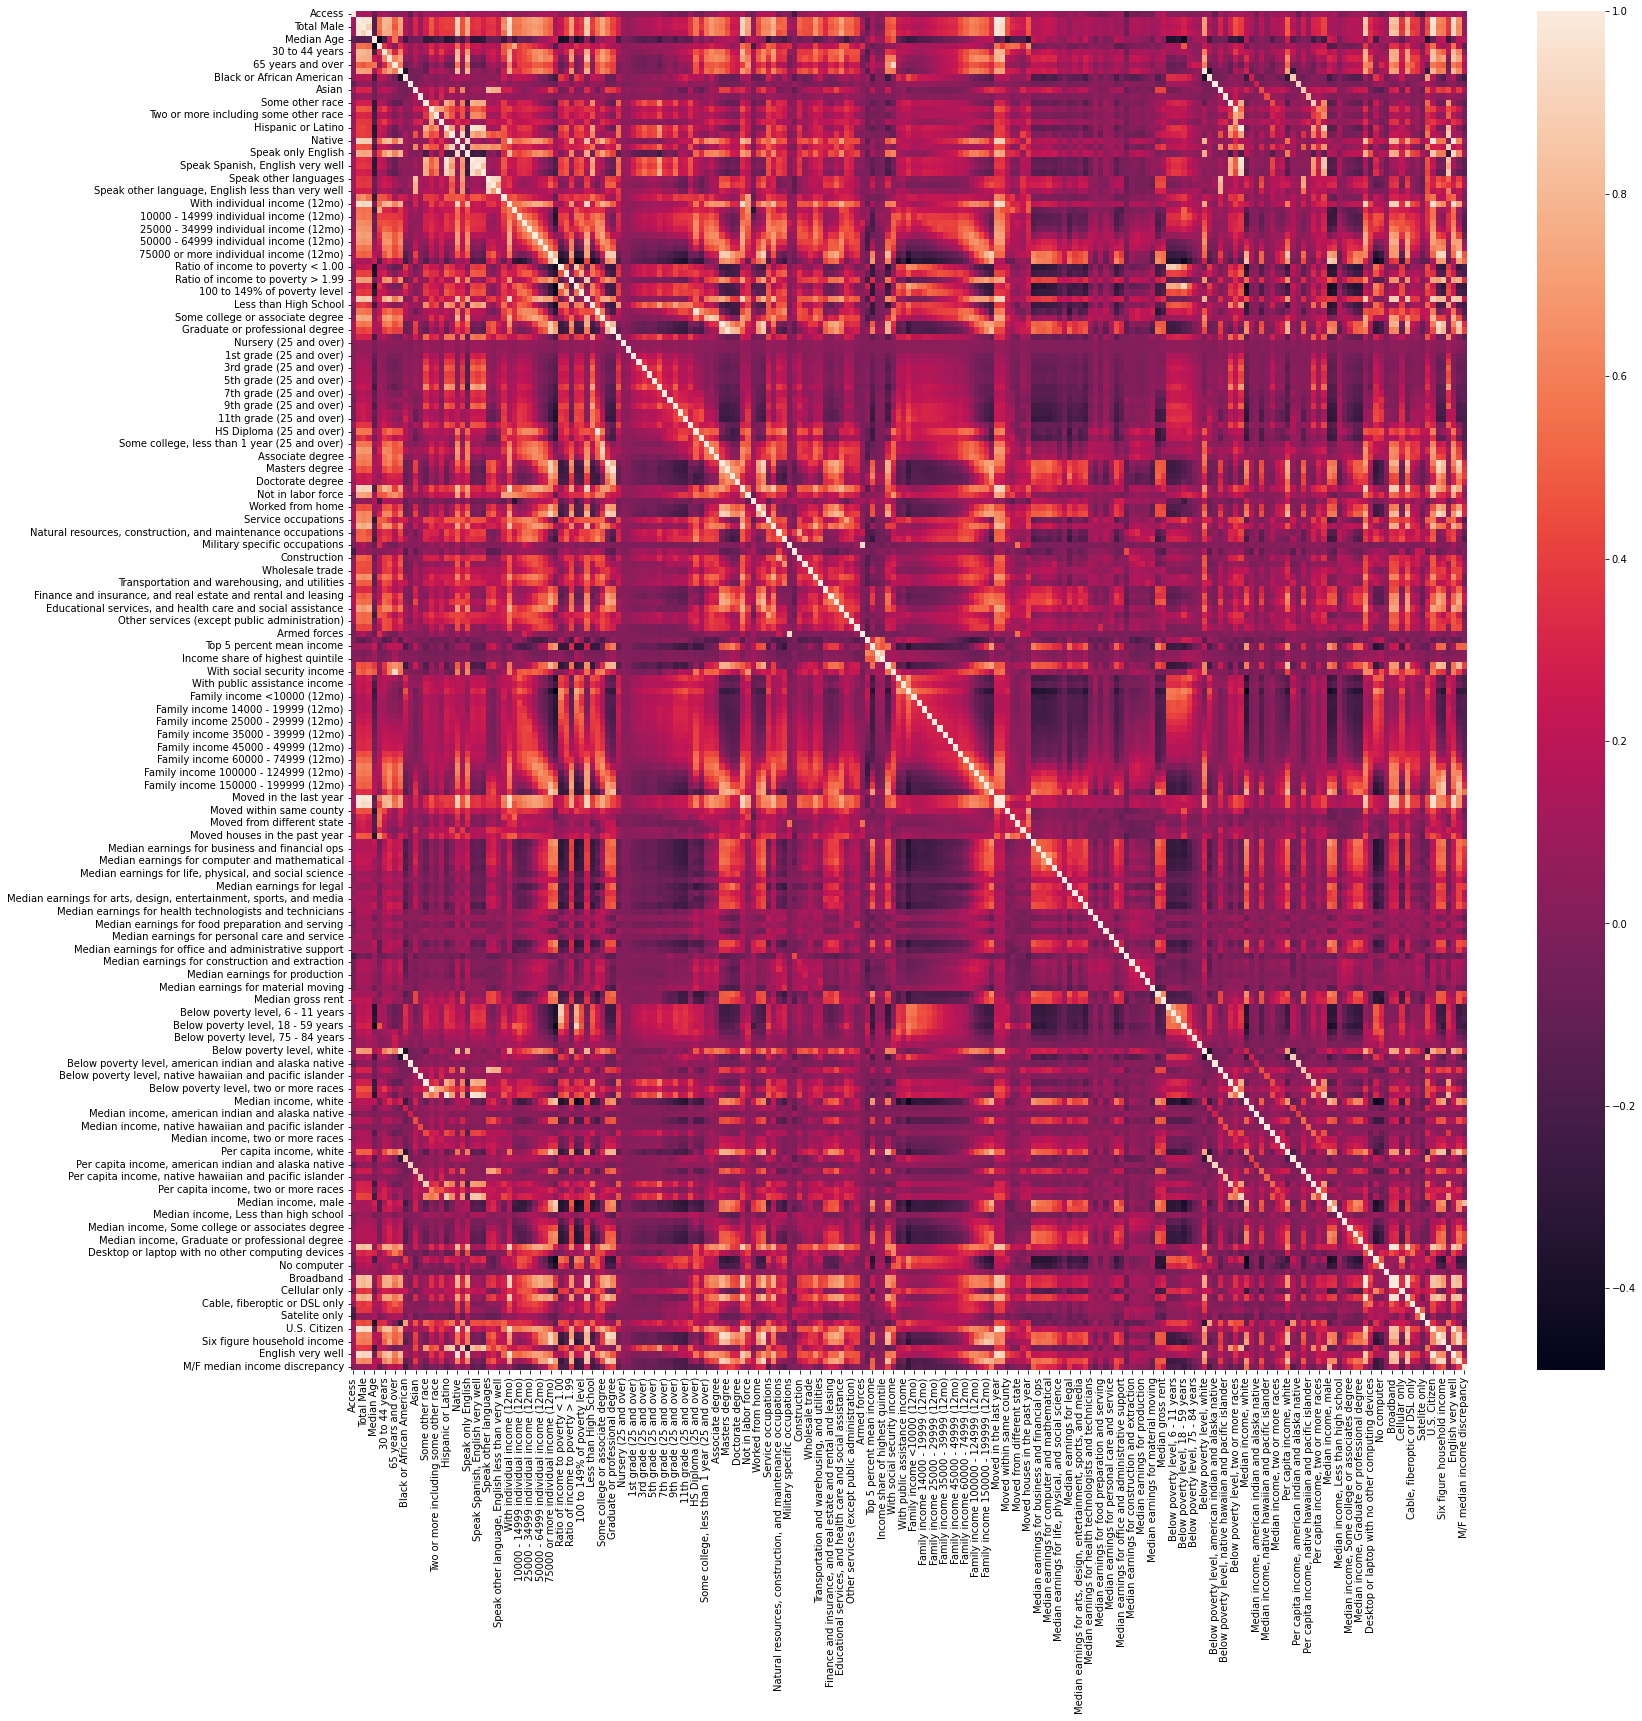

In [21]:
plt.figure(figsize=(25, 25))
sns.heatmap(correlation);

In [28]:
pearsons_corr = []
for column in non_na:
    pearsons_corr.append(pearsonr(non_na['Access'], non_na[column]))

ols = []
for column in non_na:
    ols.append(linregress(non_na['Access'], non_na[column]))

pearsons_corr = pd.DataFrame(pearsons_corr)
ols = pd.DataFrame(ols)

pearsons_results = pd.DataFrame(non_na.columns).join(pearsons_corr, lsuffix='x')
#pearsons_results.drop(['index'], inplace=True, axis=1)
pearsons_results.columns = ['column','correlation coefficient','pvalue']
pearsons_outliers = pearsons_results[pearsons_results['pvalue'] >= 0.01]
pearsons_results = pearsons_results[pearsons_results['pvalue'] < 0.01]
ols_results = pd.DataFrame(non_na.columns).join(ols)
#ols_results.drop(['index'], inplace=True, axis=1)
ols_outliers = ols_results[ols_results['pvalue'] >= 0.01]
ols_results = ols_results[ols_results['pvalue'] < 0.01]


In [22]:
access_set = non_na[non_na['Access'] == 1]

noaccess_set = non_na[non_na['Access'] == 0]

In [ ]:
#OLS Regression Implementation
#import statsmodels.api as sm

#Y = scaled.Access
#X = scaled.loc[:, scaled.columns != 'Access']

#model = sm.OLS(Y,X)

#results = model.fit()

#results.summary()

https://www.researchgate.net/post/What_is_the_minimum_value_of_correlation_coefficient_to_prove_the_existence_of_the_accepted_relationship_between_scores_of_two_of_more_tests

https://realpython.com/numpy-scipy-pandas-correlation-python/

T Test on mean
https://stackoverflow.com/questions/43292885/how-to-perform-a-t-test-on-data-stored-in-a-pandas-dataframe

Median Test


https://www.kaggle.com/code/omkardhudi/hypothesis-testing-in-python/notebook


In [23]:
#Split out blocks without access and analyze
access = non_na[non_na['Access'] == 1]

no_access = non_na[non_na['Access'] == 0]

from scipy.stats import ttest_ind
from scipy.stats import kruskal

median_comparison = pd.concat([pd.DataFrame(access.median()), pd.DataFrame(no_access.median())], axis=1, ignore_index=True)
mean_comparison = pd.concat([pd.DataFrame(access.mean()), pd.DataFrame(no_access.mean())], axis=1, ignore_index=True)

tt = ttest_ind(access, no_access)
mt = kruskal(access, no_access)

mean_comparison['t statistic'] = tt[0]
mean_comparison['p value'] = np.asarray(np.round(np.array(tt[1]),8), dtype = np.float64, order ='C')

median_comparison['h statistic'] = mt[0]
median_comparison['p value'] = np.asarray(np.round(np.array(mt[1]),8), dtype = np.float64, order ='C')

outlier_mean = mean_comparison[mean_comparison['p value'] >= 0.01]
outlier_median = median_comparison[median_comparison['p value'] >= 0.01]

mean_comparison = mean_comparison[mean_comparison['p value'] < 0.01].sort_values('t statistic')
median_comparison = median_comparison[median_comparison['p value'] < 0.01].sort_values('h statistic')


In [ ]:
no_access.describe()

,Access,Total,Total Male,Total Female,Median Age,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over,White,...,Satelite service,Satelite only,Non-white,U.S. Citizen,Degree holders,Six figure household income,English less than very well,English very well,Over 50k individual income,M/F median income discrepancy
count,5612.0,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,...,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000
mean,0.0,3375.460976,1717.483428,1657.977548,42.786725,493.796507,552.298468,883.210620,623.209729,2629.711867,...,143.877227,23.117249,745.749109,3277.025303,722.201354,255.218639,120.286885,3065.254989,635.862438,130.916058
std,0.0,1523.731380,833.211017,776.728259,8.403319,490.707366,327.147855,426.025762,329.814627,1394.964316,...,107.635502,30.113043,943.415246,1462.872327,530.263972,224.828449,261.913222,1373.333470,469.411020,128.599553
min,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-606.250000
25%,0.0,2269.000000,1127.000000,1104.000000,37.900000,261.750000,329.000000,583.000000,402.000000,1644.000000,...,66.000000,0.000000,131.000000,2210.750000,384.000000,109.750000,6.000000,2061.000000,325.000000,60.310000
50%,0.0,3217.500000,1610.500000,1578.000000,42.850000,404.000000,498.000000,837.000000,592.000000,2540.500000,...,121.000000,14.000000,384.000000,3127.000000,588.000000,194.000000,30.000000,2923.500000,518.500000,124.410000
75%,0.0,4291.000000,2170.250000,2137.000000,47.900000,592.000000,709.000000,1134.000000,802.000000,3517.000000,...,197.000000,32.000000,992.000000,4185.000000,900.000000,328.000000,109.000000,3912.500000,805.000000,188.742500
max,0.0,17213.000000,8800.000000,9694.000000,89.200000,11640.000000,3317.000000,3035.000000,3412.000000,9172.000000,...,835.000000,325.000000,10181.000000,13975.000000,4479.000000,2037.000000,4103.000000,14565.000000,4657.000000,2130.310000


In [ ]:
access.describe()

,Access,Total,Total Male,Total Female,Median Age,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over,White,...,Satelite service,Satelite only,Non-white,U.S. Citizen,Degree holders,Six figure household income,English less than very well,English very well,Over 50k individual income,M/F median income discrepancy
count,55369.0,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,...,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000,55369.000000
mean,1.0,4065.760606,1994.793711,2070.966895,39.627385,619.949412,686.645072,968.011396,632.511821,2823.077318,...,93.518575,8.293883,1242.683288,3786.945493,1164.497408,386.369015,331.865520,3490.193989,953.762159,138.036575
std,0.0,1628.823823,828.835126,845.100761,7.906528,468.996372,349.356030,458.528110,369.811844,1529.747397,...,79.776364,17.215993,1180.001764,1519.542083,789.173150,320.997459,482.572886,1425.426956,648.439538,168.869458
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1978.940000
25%,1.0,2867.000000,1394.000000,1452.000000,34.400000,359.000000,439.000000,630.000000,370.000000,1728.000000,...,39.000000,0.000000,360.000000,2674.000000,573.000000,148.000000,37.000000,2443.000000,463.000000,45.790000
50%,1.0,3932.000000,1918.000000,2000.000000,39.200000,536.000000,637.000000,909.000000,576.000000,2736.000000,...,73.000000,0.000000,871.000000,3655.000000,985.000000,298.000000,134.000000,3356.000000,818.000000,110.400000
75%,1.0,5104.000000,2503.000000,2603.000000,44.500000,765.000000,875.000000,1244.000000,821.000000,3812.000000,...,125.000000,11.000000,1770.000000,4743.000000,1589.000000,543.000000,415.000000,4386.000000,1310.000000,193.300000
max,1.0,39373.000000,27204.000000,12169.000000,85.100000,22998.000000,5664.000000,4911.000000,5789.000000,28428.000000,...,1379.000000,416.000000,10945.000000,38519.000000,11271.000000,4326.000000,5978.000000,34041.000000,8476.000000,2500.010000
